In [1]:
from paretoCardinalityRestaurants import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
def findApproximateParetoSolutionsRestaurants(simMatrix, item_ids, sample_size=None, num_runs=10, k_max=50, dataset_name=""):
    '''
    Run algorithms over multiple runs and plot mean +/- std (Objective vs Cardinality).
    Parameters:
    - simMatrix: Similarity matrix
    - item_ids: List of item ids (restaurants)
    - sample_size: Optional subsample size for items
    - num_runs: Number of independent runs
    - k_max: Maximum cardinality
    - dataset_name: Name of the dataset for plotting
    '''
    algo_names = ["C-Greedy", "TopK", "Random"]

    # Subsample items if requested
    n_items = len(item_ids)
    if sample_size is None or sample_size <= 0 or sample_size >= n_items:
        selected_indices = np.arange(n_items)
    else:
        rng = np.random.default_rng()
        selected_indices = rng.choice(n_items, size=sample_size, replace=False)
    selected_indices = np.sort(selected_indices)
    sub_items = [item_ids[i] for i in selected_indices]
    sub_sim = simMatrix[np.ix_(selected_indices, selected_indices)]

    # containers across runs
    all_objectives = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    for _ in range(num_runs):
        run_objectives = {alg: [] for alg in algo_names}
        run_runtimes = {alg: [] for alg in algo_names}

        # C-Greedy (formerly ParetoGreedy-Cardinality)
        pareto = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto.paretoGreedy()
        objectives = [pareto.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['C-Greedy'] = objectives
        run_runtimes['C-Greedy'] = runTime

        # Top K
        pareto2 = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto2.top_k()
        objectives = [pareto2.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['TopK'] = objectives
        run_runtimes['TopK'] = runTime

        # Random
        pareto3 = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto3.random_selection()
        objectives = [pareto3.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['Random'] = objectives
        run_runtimes['Random'] = runTime

        # store per-run arrays and total runtimes
        for alg in algo_names:
            arr = np.array(run_objectives[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros(k_max, dtype=float)
            all_objectives[alg].append(arr)
            all_runtimes[alg].append(run_runtimes[alg])

    # compute mean and std across runs for each algorithm
    mean_objectives = {}
    std_objectives = {}
    for alg in algo_names:
        stacked = np.vstack(all_objectives[alg])  # shape (num_runs, k_max)
        mean_objectives[alg] = np.mean(stacked, axis=0)
        std_objectives[alg] = np.std(stacked, axis=0)

    # Plot mean objective with shaded std band (match cardinality teams formatting)
    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "TopK": tab10_colors[4],
        "C-Greedy": tab10_colors[1],
        "Random": tab10_colors[7],
    }
    marker_map = {
        "TopK": "o",
        "C-Greedy": "^",
        "Random": "s",
    }
    linestyle_map = {
        "TopK": (0, (1, 1)),
        "C-Greedy": (0, (3, 2)),
        "Random": (0, (2, 2)),
    }
    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        mean = mean_objectives[alg]
        std = std_objectives[alg]
        marker_size = 7
        line_style = linestyle_map.get(alg, (0, (1, 1)))
        color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
        marker = marker_map.get(alg, 'o')
        zorder = 3
        ax.plot(range(1, k_max + 1), mean,
                label=rf"\texttt{{{alg}}}",
                color=color,
                linestyle=line_style,
                marker=marker,
                markersize=marker_size,
                markevery=15,
                markeredgewidth=1.1,
                markeredgecolor='k',
                linewidth=1.8,
                zorder=zorder)
        ax.fill_between(range(1, k_max + 1),
                        np.clip(mean - std, 0, None),
                        mean + std,
                        color=color,
                        alpha=0.18,
                        zorder=2)
    
    ax.set_xlabel(r'Cardinality, $k$', fontsize=28)
    ax.set_ylabel(r'Objective, $f$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)
    
    # Legend handles (saved separately)
    handles, labels = ax.get_legend_handles_labels()
    
    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "cardinality"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_cardinality.pdf"
    fig.savefig(out_path, bbox_inches="tight")
    
    # Save legend as separate PDF
    if handles:
        legend_out_path = plots_dir / "cardinality_legend.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(handles, labels, loc='center', ncol=3, fontsize=22, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)
    
    plt.show()
    
    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))
    
    return None

### Yelp Phoenix Experiments

In [3]:
#Import Yelp Phoenix dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    phoenix_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    phoenix_simMatrix = pickle.load(fp)

2026-02-07 21:12:37,813 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:1000, k_max=500
2026-02-07 21:14:27,637 |INFO: Cardinality Greedy Solution:[122, 128, 371, 642, 606, 199, 791, 624, 146, 499, 79, 236, 240, 308, 366, 500, 22, 436, 545, 632, 445, 25, 150, 793, 718, 424, 135, 47, 256, 580, 24, 423, 629, 286, 54, 353, 457, 379, 238, 145, 219, 93, 141, 254, 245, 881, 375, 796, 374, 831, 574, 129, 160, 170, 406, 239, 171, 212, 56, 268, 834, 194, 13, 845, 502, 165, 994, 767, 671, 274, 628, 761, 507, 291, 623, 325, 90, 692, 108, 161, 643, 597, 350, 121, 74, 68, 551, 581, 154, 214, 771, 172, 20, 89, 621, 830, 420, 133, 653, 598, 55, 269, 873, 211, 397, 674, 575, 478, 232, 974, 472, 494, 487, 123, 706, 544, 661, 847, 377, 735, 46, 638, 582, 727, 233, 701, 18, 416, 843, 49, 835, 196, 630, 904, 346, 501, 65, 584, 640, 978, 949, 797, 91, 205, 955, 100, 937, 914, 221, 263, 306, 5, 373, 14, 314, 708, 573, 611, 66, 792, 608, 687, 966, 874, 899, 519, 313, 1, 253,

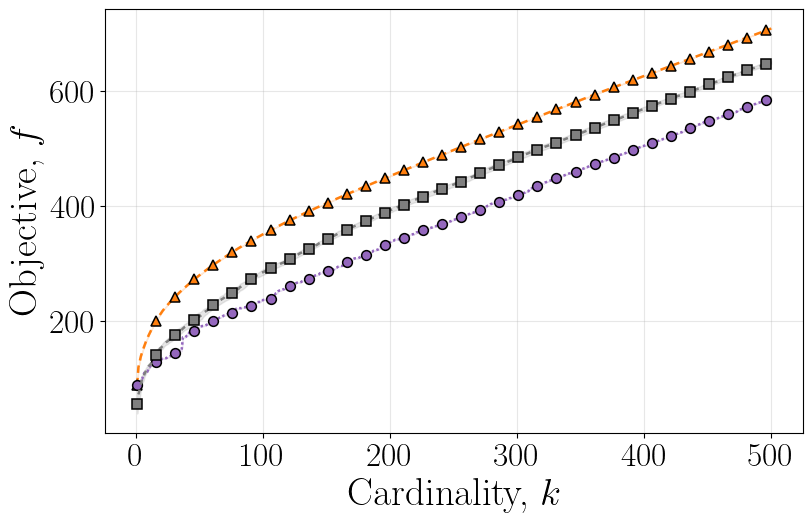

2026-02-07 21:29:57,262 |INFO: Runtime summary (mean ± std, seconds):
  - C-Greedy: 107.340 ± 2.057
  - TopK: 63.632 ± 0.936
  - Random: 36.767 ± 0.771


In [4]:
# Adjust parameters as needed
sample_size = 1000
num_runs = 5  # number of random runs
k_max = 500
findApproximateParetoSolutionsRestaurants(phoenix_simMatrix, phoenix_ids, sample_size, num_runs, k_max, "Yelp_Phoenix")

### Yelp Vegas Experiments

In [5]:
#Import Yelp Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    vegas_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    vegas_simMatrix = pickle.load(fp)

2026-02-07 21:29:57,319 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:1200, k_max=600
2026-02-07 21:32:58,105 |INFO: Cardinality Greedy Solution:[706, 488, 85, 1009, 766, 308, 828, 205, 374, 144, 135, 167, 323, 369, 517, 911, 674, 301, 665, 792, 953, 881, 640, 54, 50, 233, 446, 46, 675, 725, 12, 293, 385, 754, 375, 163, 364, 824, 288, 1049, 940, 304, 904, 197, 680, 315, 263, 6, 335, 958, 784, 476, 770, 860, 1032, 1046, 964, 320, 30, 1039, 438, 281, 876, 511, 245, 361, 345, 542, 246, 748, 668, 19, 518, 715, 479, 815, 810, 713, 149, 817, 1034, 912, 379, 225, 105, 656, 130, 780, 1006, 827, 519, 316, 710, 81, 436, 292, 414, 894, 505, 382, 65, 772, 102, 71, 590, 1182, 963, 981, 286, 736, 844, 996, 275, 186, 280, 629, 451, 49, 69, 1061, 332, 1012, 17, 728, 475, 411, 115, 489, 893, 1189, 995, 1023, 1066, 799, 862, 162, 427, 874, 1088, 737, 91, 686, 707, 426, 1141, 339, 228, 969, 544, 1045, 170, 289, 959, 1173, 366, 562, 1139, 77, 557, 243, 1158, 1056, 740, 

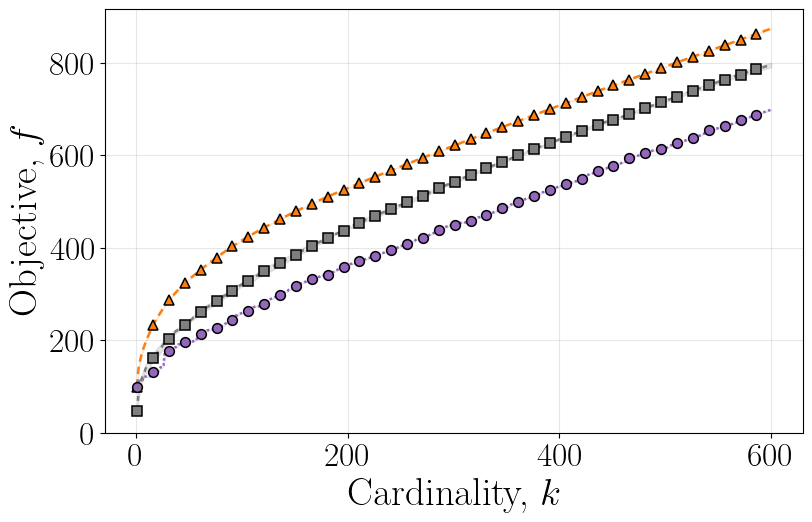

2026-02-07 21:59:21,161 |INFO: Runtime summary (mean ± std, seconds):
  - C-Greedy: 180.846 ± 1.170
  - TopK: 108.900 ± 1.070
  - Random: 62.951 ± 1.323


In [6]:
# Adjust parameters as needed
sample_size = 1200
num_runs = 5  # number of random runs
k_max = 600
findApproximateParetoSolutionsRestaurants(vegas_simMatrix, vegas_ids, sample_size, num_runs, k_max, "Yelp_Vegas")